# Backtest Model Predictions
This workbook evalautes the model predictions to see how profitable our portfolio would be on historical data. Our neural net models were trained on data from 01/01/2000 through 02/28/2021. We will now test the predictions on the period 03/01/2021 through 04/16/2021.
## Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from datetime import datetime
import pickle
import time
import os
from scipy.optimize import minimize

# Neural Networks
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import copy

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

# Data Locations
datadir = '../../Data/RawComments/'
datadir2 = '../../Data/SourceData/'
stockdata = '../../Data/StockData/'
testdata = '../../Data/Test/'
processedinputs = '../../Data/ProcessedInputs/'
plotdir = '../../Outputs/Plots/'
savedmodels = '../../Data/Models/'
outputdir = '../../Data/Predictions/'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load Prediction Data and Merge

In [2]:
dfs = ['SPY','AAPL','AMC','BB','F','GME','GRWG','MO','NIO','PLTR','RKT','SNDL','TLRY','TSLA','VIAC']
df_dict = {}
for df in dfs:
    with open(outputdir+df+'_pred.bin','rb') as f:
        df_dict[df] = pickle.load(f)

In [3]:
df = df_dict['SPY']
df = df[['Open','Raw_Predictions']]
df.columns = ['SPY_Price','SPY_Change']
df['SPY_Buy'] = df['SPY_Change']
df['SPY_Buy'] = df['SPY_Buy'] / df['SPY_Buy'].abs()
df['SPY_Buy'] = df['SPY_Buy'].replace(-1,0)
df['SPY_Change'] = df['SPY_Change']

for tickr, t_df in df_dict.items():
    if tickr == 'SPY':
        pass
    else:
        new_df = t_df
        t = tickr.upper()
        new_df = new_df[['Open','Raw_Predictions']]
        new_df.columns = [t+'_Price',t+'_Change']
        new_df[t+'_Buy'] = new_df[t+'_Change']
        new_df[t+'_Buy'] = new_df[t+'_Buy'] / new_df[t+'_Buy'].abs()
        new_df[t+'_Buy'] = new_df[t+'_Buy'].replace(-1,0)
        new_df[t+'_Change'] = new_df[t+'_Change']
        df = df.merge(new_df,how='left',left_index=True,right_index=True)

C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [4]:
df = df[-37:].fillna(0)

In [5]:
df

,SPY_Price,SPY_Change,SPY_Buy,AAPL_Price,AAPL_Change,AAPL_Buy,AMC_Price,AMC_Change,AMC_Buy,BB_Price,...,SNDL_Buy,TLRY_Price,TLRY_Change,TLRY_Buy,TSLA_Price,TSLA_Change,TSLA_Buy,VIAC_Price,VIAC_Change,VIAC_Buy
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,385.589996,-0.000275,0.0,123.750000,0.002300,1.0,8.86,0.007470,1.0,10.29,...,1.0,25.120001,0.026457,1.0,690.109985,0.015086,1.0,64.800003,0.047923,1.0
2021-03-02,389.820007,-0.000759,0.0,128.410004,-0.000277,0.0,9.14,0.007680,1.0,10.90,...,1.0,26.160000,0.033678,1.0,718.280029,-0.005688,0.0,67.309998,0.024560,1.0
2021-03-03,385.790009,-0.000290,0.0,124.809998,0.002560,1.0,8.95,0.007498,1.0,10.48,...,1.0,26.580000,-0.003299,0.0,687.989990,-0.002456,0.0,69.129997,0.016824,1.0
2021-03-04,381.220001,0.000988,1.0,121.750000,0.002542,1.0,8.25,0.007616,1.0,10.01,...,1.0,24.950001,-0.016799,0.0,655.799988,0.004672,1.0,70.540001,0.008643,1.0
2021-03-05,380.459991,0.001866,1.0,120.980003,-0.006092,0.0,8.08,0.007616,1.0,9.80,...,1.0,22.990000,-0.046904,0.0,626.059998,0.005553,1.0,71.099998,0.029036,1.0
2021-03-08,384.660004,0.002164,1.0,120.930000,-0.000613,0.0,8.53,0.007616,1.0,9.39,...,1.0,21.730000,0.000921,1.0,600.549988,0.006186,1.0,74.879997,0.020633,1.0
2021-03-09,385.850006,0.002164,1.0,119.029999,0.004602,1.0,9.38,0.007616,1.0,10.19,...,1.0,23.230000,-0.001880,0.0,608.179993,0.006186,1.0,84.400002,0.025065,1.0
2021-03-10,389.690002,0.002164,1.0,121.690002,0.002013,1.0,11.02,0.007616,1.0,11.01,...,1.0,26.740000,0.035248,1.0,700.299988,0.006186,1.0,79.970001,0.034069,1.0
2021-03-11,392.230011,0.002164,1.0,122.540001,0.000966,1.0,10.65,0.007616,1.0,10.55,...,1.0,24.770000,-0.030004,0.0,699.400024,0.006186,1.0,82.910004,0.027755,1.0


## Backtest

In [6]:
startperiod = 0
portfolio = dh.Portfolio(processedinputs+'covariance_matrix.bin',0.01,starting_balance=100000)

In [7]:
price_cols = [stock+'_Price' for stock in portfolio.stocks]
buy_cols = [stock+'_Buy' for stock in portfolio.stocks]
pred_cols = [stock+'_Change' for stock in portfolio.stocks]

In [8]:
for idx, row in df[startperiod:].iterrows():
    print(f'\nStep {idx}')
    prices = row[price_cols].to_numpy()
    buys = row[buy_cols].to_numpy()
    predictions = row[pred_cols].to_numpy()
    portfolio.setExpectedReturns(predictions)
    portfolio.rebalancePortfolio(period=idx, prices=prices,pprint=False)
    #portfolio.rebalancePortfolioOld(period=idx, prices=prices,buys=buys,weights=predictions,pprint=False)



Step 2021-03-01 00:00:00
Current Value: $100000.00

Step 2021-03-02 00:00:00
Current Value: $104253.92

Step 2021-03-03 00:00:00
Current Value: $120428.67

Step 2021-03-04 00:00:00
Current Value: $117738.19

Step 2021-03-05 00:00:00
Current Value: $117752.64

Step 2021-03-08 00:00:00
Current Value: $122770.10

Step 2021-03-09 00:00:00
Current Value: $131992.75

Step 2021-03-10 00:00:00
Current Value: $135120.23

Step 2021-03-11 00:00:00
Current Value: $138139.36

Step 2021-03-12 00:00:00
Current Value: $140920.95

Step 2021-03-15 00:00:00
Current Value: $150335.89

Step 2021-03-16 00:00:00
Current Value: $154093.54

Step 2021-03-17 00:00:00
Current Value: $151854.48

Step 2021-03-18 00:00:00
Current Value: $154828.13

Step 2021-03-19 00:00:00
Current Value: $153096.82

Step 2021-03-22 00:00:00
Current Value: $157612.31

Step 2021-03-23 00:00:00
Current Value: $156620.66

Step 2021-03-24 00:00:00
Current Value: $144599.40

Step 2021-03-25 00:00:00
Current Value: $137670.81

Step 2021-0

## Backtest Baseline
Let's create a baseline forecast to see if the predictions actually add value. It may be that all of the stocks we picked in our portfolio were naturally profitable during this period, so it wouldn't have mattered which ones we invest in. Therefore, we will create a baseline portfolio where we hold equal amounts of each stock throughout the entire period.

In [9]:
portfolio2 = dh.Portfolio(processedinputs+'covariance_matrix.bin',0.01,starting_balance=100000,expected_returns=processedinputs+'covariance_matrix.bin')

In [10]:
for idx, row in df[startperiod:].iterrows():
    print(f'\nStep {idx}')
    prices = row[price_cols].to_numpy()
    portfolio2.rebalancePortfolio(period=idx, prices=prices,pprint=False)
    #portfolio2.rebalancePortfolioOld(period=idx, prices=prices,buys=buys,weights=None,pprint=False)


Step 2021-03-01 00:00:00
Current Value: $100000.00

Step 2021-03-02 00:00:00
Current Value: $101097.02

Step 2021-03-03 00:00:00
Current Value: $100051.87

Step 2021-03-04 00:00:00
Current Value: $98866.67

Step 2021-03-05 00:00:00
Current Value: $98669.57

Step 2021-03-08 00:00:00
Current Value: $99758.81

Step 2021-03-09 00:00:00
Current Value: $100067.43

Step 2021-03-10 00:00:00
Current Value: $101063.31

Step 2021-03-11 00:00:00
Current Value: $101722.04

Step 2021-03-12 00:00:00
Current Value: $101680.54

Step 2021-03-15 00:00:00
Current Value: $102266.65

Step 2021-03-16 00:00:00
Current Value: $102977.26

Step 2021-03-17 00:00:00
Current Value: $102318.53

Step 2021-03-18 00:00:00
Current Value: $102305.56

Step 2021-03-19 00:00:00
Current Value: $101112.58

Step 2021-03-22 00:00:00
Current Value: $101151.48

Step 2021-03-23 00:00:00
Current Value: $101639.05

Step 2021-03-24 00:00:00
Current Value: $101403.05

Step 2021-03-25 00:00:00
Current Value: $100101.15

Step 2021-03-2

## Results
### Portfolio Balance Over Time

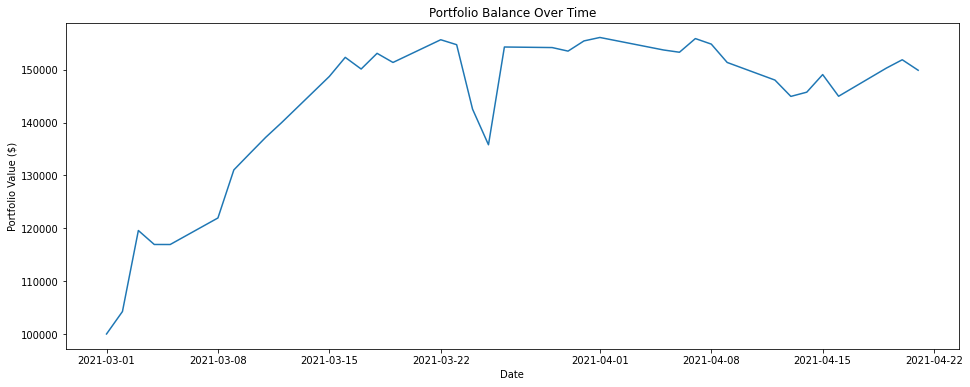

In [54]:
portfolio.plotHist()

### Portfolio Returns compared to S&P 500

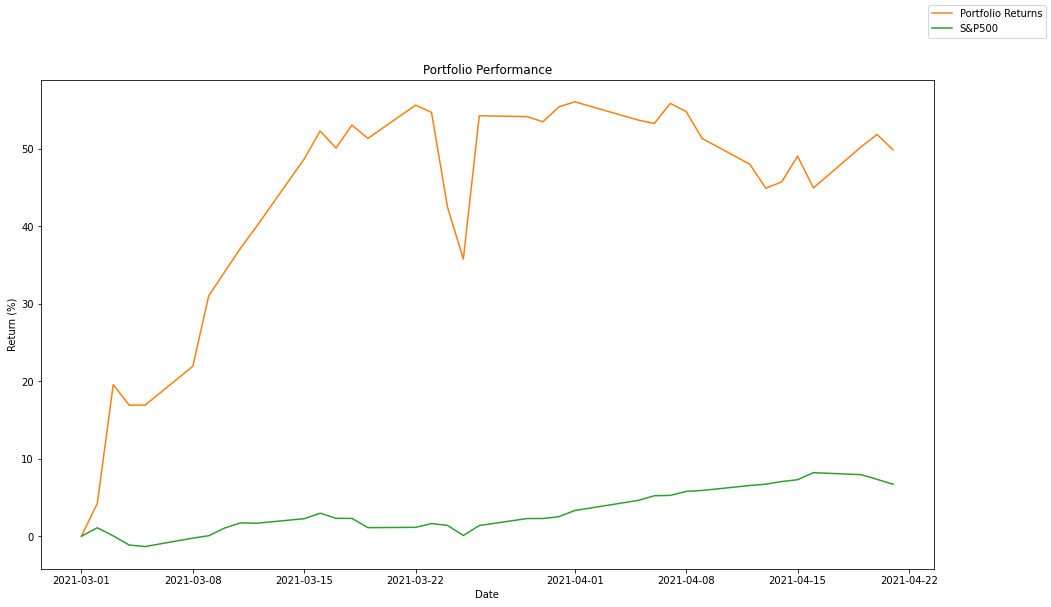

In [55]:
portfolio.plotReturns()

### Comparison to Baseline Forecast

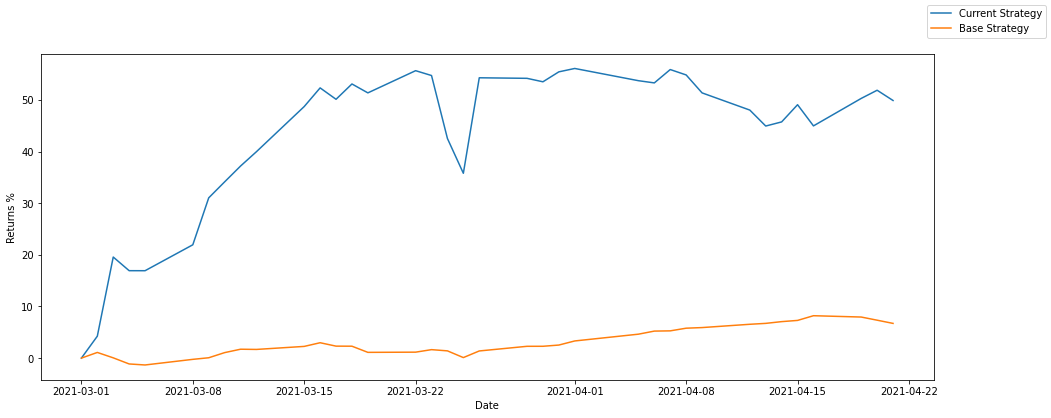

In [56]:
portfolio.comparePortfolios(portfolio2)

### Investment Mix throughout Time

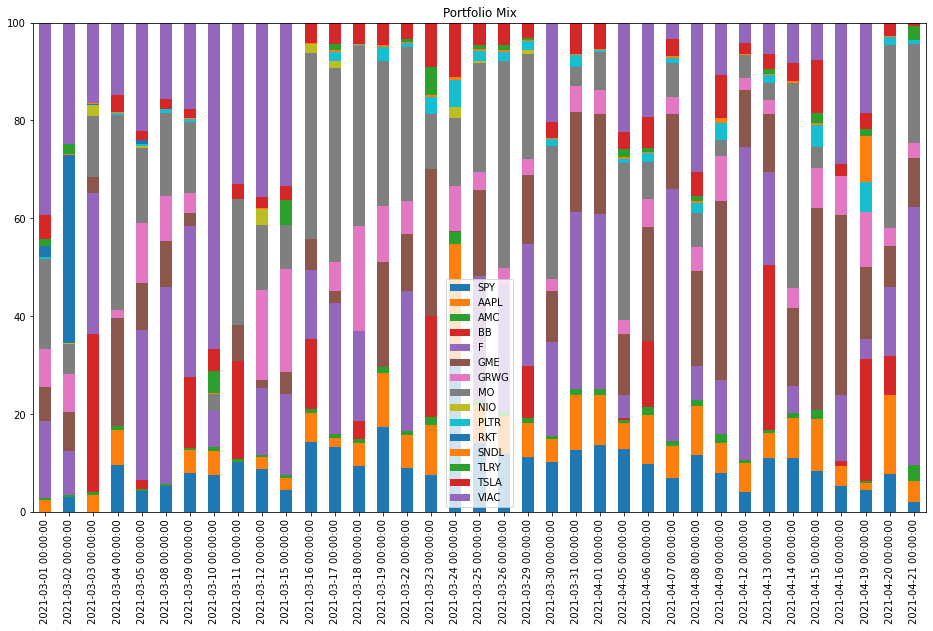

In [57]:
portfolio.plotInvestment()

## Total Profits

In [58]:
pd.DataFrame([value for key, value in portfolio.profits.items()],index=[key for key, value in portfolio.profits.items()],columns=['Total Profits']).style.format('${0:,.2f}')

,Total Profits
SPY,$990.47
AAPL,$-67.38
AMC,"$-3,520.59"
BB,"$-3,072.28"
F,"$-1,389.60"
GME,"$-1,668.12"
GRWG,"$4,581.14"
MO,"$11,955.08"
NIO,$-847.41
PLTR,$-718.79


In [59]:
initial_bal = portfolio.hist_bal[0]
returns = pd.Series(portfolio.hist_bal,index=portfolio.hist_period)
returns = (returns-initial_bal) / initial_bal * 100
sharpe_returns = [returns[:i].mean() / returns[:i].std() for i in range(len(returns))]

In [60]:
returns

2021-03-01     0.000000
2021-03-02     4.247118
2021-03-03    19.576908
2021-03-04    16.933196
2021-03-05    16.927274
2021-03-08    21.949252
2021-03-09    31.041445
2021-03-10    34.136694
2021-03-11    37.199524
2021-03-12    39.984496
2021-03-15    48.724651
2021-03-16    52.338177
2021-03-17    50.130051
2021-03-18    53.098946
2021-03-19    51.373137
2021-03-22    55.671692
2021-03-23    54.733259
2021-03-24    42.534428
2021-03-25    35.800169
2021-03-26    54.296340
2021-03-29    54.190832
2021-03-30    53.519722
2021-03-31    55.446350
2021-04-01    56.101097
2021-04-05    53.733559
2021-04-06    53.304689
2021-04-07    55.891910
2021-04-08    54.845414
2021-04-09    51.371052
2021-04-12    48.039662
2021-04-13    44.949496
2021-04-14    45.750020
2021-04-15    49.079497
2021-04-16    44.977842
2021-04-19    50.300371
2021-04-20    51.883546
2021-04-21    49.896338
dtype: float64

In [61]:
sharpe_returns

[nan,
 nan,
 0.7071067811865475,
 0.7711519882557999,
 1.0686410037270535,
 1.3124975127180836,
 1.4849894710606508,
 1.4961546470194476,
 1.542575542963095,
 1.5937646641761634,
 1.6447600266019269,
 1.630194772869267,
 1.6345709441965708,
 1.6854543244942228,
 1.728624882636963,
 1.7876920089889303,
 1.8304154750977193,
 1.8819967188975233,
 1.9539245184017513,
 2.0127853755833782,
 2.0595012881695816,
 2.107571759445895,
 2.1579162494018926,
 2.202528365435256,
 2.245551336581461,
 2.2948029581958314,
 2.344253226959458,
 2.387297405424017,
 2.4325428459037868,
 2.482500273051973,
 2.5330247655791025,
 2.5809077354069037,
 2.6286353580159445,
 2.6761840581069785,
 2.721520331389764,
 2.76671031791109,
 2.8095838438039697]

In [69]:
def plotSharpeReturns(self):        
    fig, ax = plt.subplots(figsize=(16,9))
    initial_bal = self.hist_bal[0]
    returns = pd.Series(self.hist_bal,index=self.hist_period)
    returns = returns.pct_change()[1:] * 100
    #returns = (returns-initial_bal) / initial_bal * 100
    #sharpe_returns = [returns[:i].mean() / returns[:i].std() for i in range(len(returns))]
    #sharpe_returns = pd.Series(sharpe_returns,index=self.hist_period)
    sharpe_returns = returns/returns.std()

    spy = pd.Series(self.spy_prices,index=self.hist_period)
    spy_initial = spy[0]
    spy = spy.pct_change()[1:] * 100
    #spy = (spy - spy_initial) / spy_initial * 100
    #spy_sharpe_returns = [spy[:i].mean() / spy[:i].std() for i in range(len(spy))]
    #spy_sharpe_returns = pd.Series(spy_sharpe_returns,index=self.hist_period)
    spy_sharpe_returns = spy/spy.std()
    ax.set_title('Portfolio Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return (%)')  
    ax.plot(sharpe_returns, color='C1',label='Portfolio Returns')
    ax.plot(spy_sharpe_returns, color='C2',label='S&P500')

    fig.legend()
    plt.show()
    print(returns.mean()/returns.std())
    print(spy.mean()/spy.std())

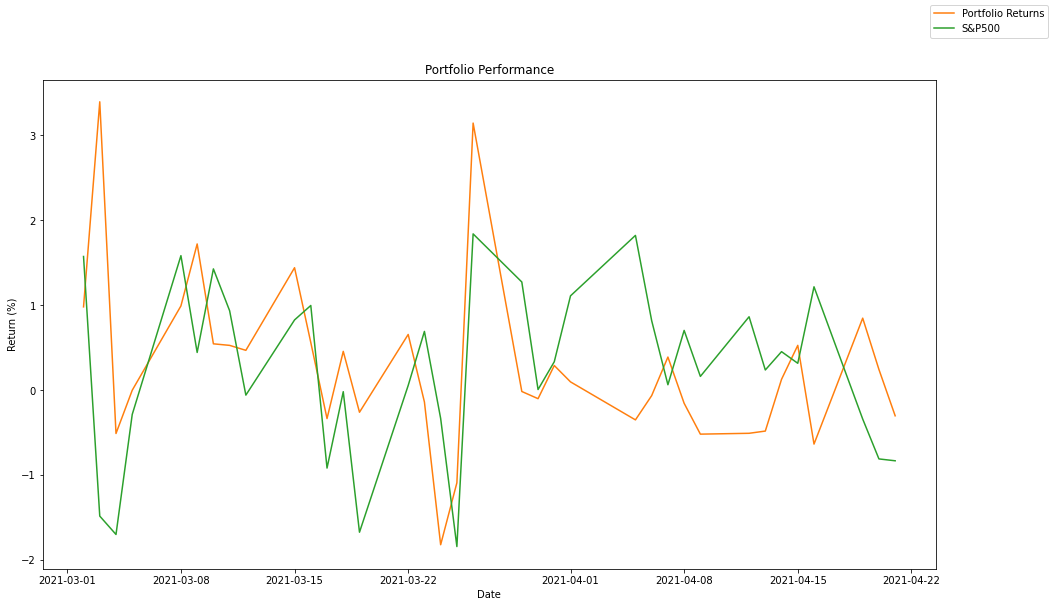

0.2812217555476346
0.2628791422536285


In [70]:
plotSharpeReturns(portfolio)

In [64]:
a = pd.DataFrame({'Portfolio Value':portfolio.hist_bal,
                 'SPY Price': portfolio.spy_prices},index=portfolio.hist_period)

In [65]:
a

,Portfolio Value,SPY Price
2021-03-01,100000.000000,385.589996
2021-03-02,104247.117524,389.820007
2021-03-03,119576.908311,385.790009
2021-03-04,116933.196001,381.220001
2021-03-05,116927.273947,380.459991
2021-03-08,121949.251997,384.660004
2021-03-09,131041.445233,385.850006
2021-03-10,134136.694138,389.690002
2021-03-11,137199.524019,392.230011
2021-03-12,139984.495743,392.070007


In [66]:
a.to_csv('returns_new.csv')

In [67]:
portfolio.hist_bal

[100000.0,
 104247.11752398103,
 119576.9083113176,
 116933.19600078595,
 116927.27394708626,
 121949.25199725264,
 131041.44523332581,
 134136.69413798247,
 137199.52401866316,
 139984.4957434939,
 148724.65149053416,
 152338.1768197255,
 150130.0505944527,
 153098.94572173656,
 151373.1368483434,
 155671.69175225843,
 154733.2589950135,
 142534.4280310496,
 135800.16881524536,
 154296.3402868775,
 154190.8324161459,
 153519.72152648095,
 155446.35043887884,
 156101.0974533993,
 153733.55861680483,
 153304.68878454412,
 155891.9104238589,
 154845.41449564416,
 151371.05157899763,
 148039.6619681652,
 144949.4963141959,
 145750.02047924342,
 149079.49685826537,
 144977.84243685685,
 150300.3705013296,
 151883.5459914154,
 149896.3381103818]

In [68]:
portfolio.hist_period

[Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-03-02 00:00:00'),
 Timestamp('2021-03-03 00:00:00'),
 Timestamp('2021-03-04 00:00:00'),
 Timestamp('2021-03-05 00:00:00'),
 Timestamp('2021-03-08 00:00:00'),
 Timestamp('2021-03-09 00:00:00'),
 Timestamp('2021-03-10 00:00:00'),
 Timestamp('2021-03-11 00:00:00'),
 Timestamp('2021-03-12 00:00:00'),
 Timestamp('2021-03-15 00:00:00'),
 Timestamp('2021-03-16 00:00:00'),
 Timestamp('2021-03-17 00:00:00'),
 Timestamp('2021-03-18 00:00:00'),
 Timestamp('2021-03-19 00:00:00'),
 Timestamp('2021-03-22 00:00:00'),
 Timestamp('2021-03-23 00:00:00'),
 Timestamp('2021-03-24 00:00:00'),
 Timestamp('2021-03-25 00:00:00'),
 Timestamp('2021-03-26 00:00:00'),
 Timestamp('2021-03-29 00:00:00'),
 Timestamp('2021-03-30 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-04-05 00:00:00'),
 Timestamp('2021-04-06 00:00:00'),
 Timestamp('2021-04-07 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-

In [29]:
from matplotlib.lines import Line2D
def plotReturns(self):        
    plt.style.use("seaborn-dark")
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = 'black'#'#212946'  # bluish dark grey
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  # very light grey
    background_color = 'black'

    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        
        '#00ff41',  # matrix green
        '#F5D300',  # yellow
    ]

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(11,5))
    initial_bal = self.hist_bal[0]
    returns = pd.Series(self.hist_bal,index=self.hist_period)
    returns = (returns-initial_bal) / initial_bal * 100

    spy = pd.Series(self.spy_prices,index=self.hist_period)
    spy_initial = spy[0]
    spy = (spy - spy_initial) / spy_initial * 100
    ax.set_title('Portfolio Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return (%)')  
    ax.plot(returns, color=colors[3],label='Portfolio Returns')
    ax.plot(spy, color=colors[0],label='S&P500')
    
    n_shades = 10
    diff_linewidth = 1.05
    alpha_value = 0.3 / n_shades

    for n in range(1, n_shades+1):
        returns.plot(
                linewidth=4+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
            ax=ax,
                color=colors[3])
        spy.plot(
                linewidth=2+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
            ax=ax,
                color=colors[0])
    legend_elements = [Line2D([0], [0], color=colors[3], label='Portfolio Returns'),
                      Line2D([0], [0], color=colors[0], label='S&P500'),]
    #ax.get_legend().remove()
    ax.legend(handles=legend_elements)
    plt.tight_layout()
    plt.show()

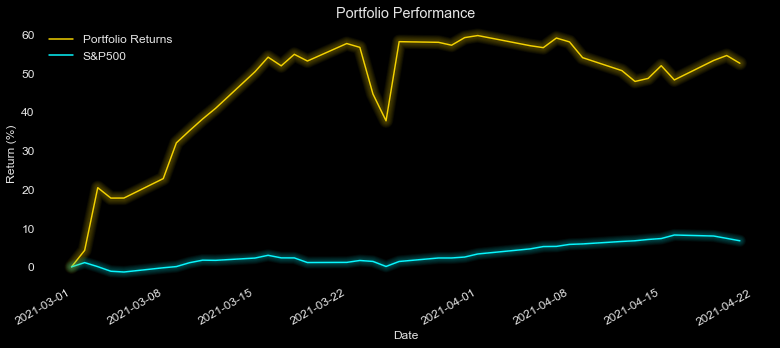

In [30]:
plotReturns(portfolio)

In [31]:
def plotSharpeReturns(self):        
    plt.style.use("seaborn-dark")
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = 'black'#'#212946'  # bluish dark grey
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  # very light grey
    background_color = 'black'

    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        
        '#00ff41',  # matrix green
        '#F5D300',  # yellow
    ]

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(11,5))
    initial_bal = self.hist_bal[0]
    returns = pd.Series(self.hist_bal,index=self.hist_period)
    returns = returns.pct_change()[1:] * 100
    #returns = (returns-initial_bal) / initial_bal * 100
    #sharpe_returns = [returns[:i].mean() / returns[:i].std() for i in range(len(returns))]
    #sharpe_returns = pd.Series(sharpe_returns,index=self.hist_period)
    sharpe_returns = returns/returns.std()

    spy = pd.Series(self.spy_prices,index=self.hist_period)
    spy_initial = spy[0]
    spy = spy.pct_change()[1:] * 100
    #spy = (spy - spy_initial) / spy_initial * 100
    #spy_sharpe_returns = [spy[:i].mean() / spy[:i].std() for i in range(len(spy))]
    #spy_sharpe_returns = pd.Series(spy_sharpe_returns,index=self.hist_period)
    spy_sharpe_returns = spy/spy.std()
    ax.set_title('Portfolio Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sharpe Return')  
    ax.plot(sharpe_returns, color=colors[3],label='Portfolio Returns')
    ax.plot(spy_sharpe_returns, color=colors[0],label='S&P500')
    
    n_shades = 10
    diff_linewidth = 1.05
    alpha_value = 0.3 / n_shades

    for n in range(1, n_shades+1):
        sharpe_returns.plot(
                linewidth=4+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
            ax=ax,
                color=colors[3])
        spy_sharpe_returns.plot(
                linewidth=2+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
            ax=ax,
                color=colors[0])
    legend_elements = [Line2D([0], [0], color=colors[3], label='Portfolio Returns'),
                      Line2D([0], [0], color=colors[0], label='S&P500'),]
    #ax.get_legend().remove()
    ax.legend(handles=legend_elements)
    plt.tight_layout()
    plt.show()
    print(returns.mean()/returns.std())
    print(spy.mean()/spy.std())

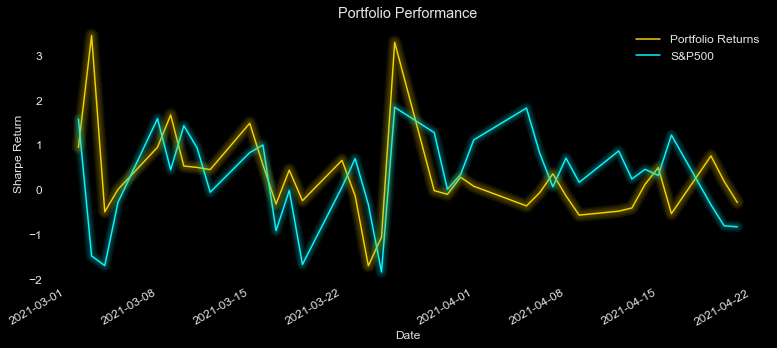

0.28251481599877304
0.2628791422536285


In [32]:
plotSharpeReturns(portfolio)